In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

Пункт 1: генерация изображения с последовательностью символов (20% начертаний)

In [ ]:
# Генератор случайных последовательностей
# На выходе - массив строк и массив массивов изображений, соответствующих строкам
# Предположено тестирование на последних 20% каждого файла с начертаниями
# Предположено обучение модели на первых 80% каждого файла с начертаниями

class SymbolGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.available_symbols = list(('(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*'))
        print("Доступные символы:", self.available_symbols)
        
    def get_random_symbol_image(self, char):
        folder_name = char
        if (char == 'x'):
            folder_name = 'X'
        if (char == '*'):
            folder_name = 'times'
        symbol_dir = os.path.join(self.data_path, folder_name)
        
        images = [f for f in os.listdir(symbol_dir)]
        images.sort() 
        start_index = int(len(images) * 0.8)
        last_30_percent = images[start_index:]

        random_image = random.choice(last_30_percent)
        img_path = os.path.join(symbol_dir, random_image)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    
        return img
    
    def generate_sequence(self, length=4):
        sequence = ''.join(random.choices(self.available_symbols, k=length))
        print(f"Генерируем: {sequence}")
        images = []
        
        for char in sequence:
            img = self.get_random_symbol_image(char)
            if img is not None:
                images.append(img)
        
        return sequence, images

generator = SymbolGenerator('C:\\improc\\hw9\\')

Доступные символы: ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*']


In [3]:
# Функция склейки тестовых изображений
# На входе - массив начертаний символов последовательности
# На выходе - изображение последовательности

def create_sequence_image(images, spacing=20):
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    max_height = max(img.shape[0] for img in images)
    
    sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255
    
    x_offset = 0
    for img in images:
        h, w = img.shape
        y_offset = (max_height - h)
        sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + spacing
    
    return sequence_img

Генерируем: ytx4463+2)


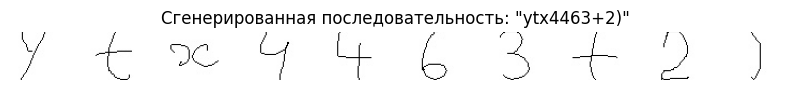

In [4]:
sequence, images = generator.generate_sequence(length=10)
sequence_image = create_sequence_image(images, spacing=30)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(sequence_image, cmap='gray')
ax.set_title(f'Сгенерированная последовательность: "{sequence}"')
ax.axis('off')

plt.tight_layout()
plt.show()

Пункт 2: выделение объектов opencv

Обрабатываем последовательность: 'ytx4463+2)'


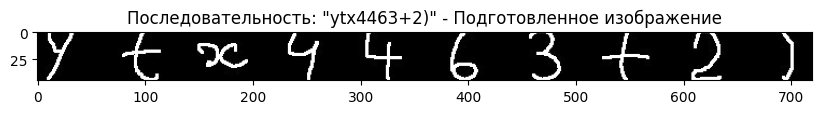

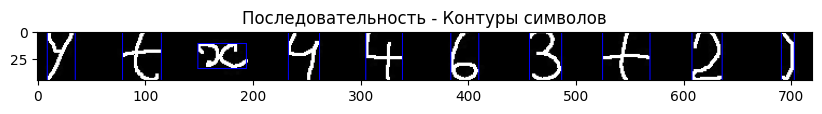

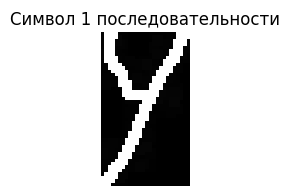

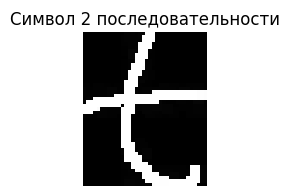

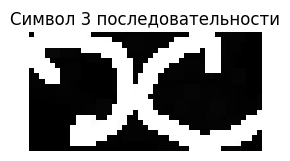

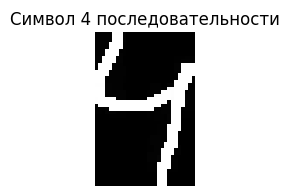

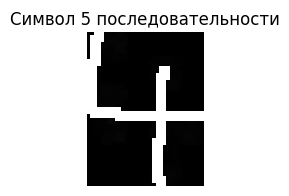

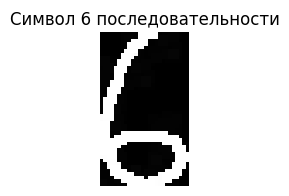

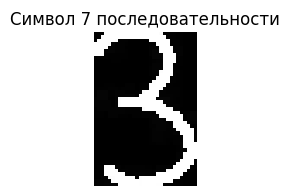

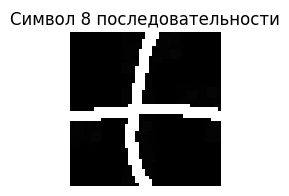

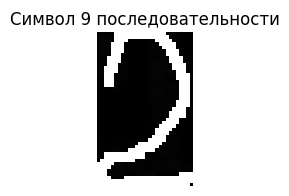

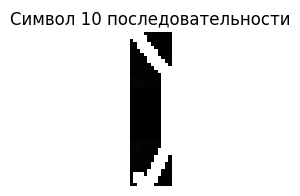

In [ ]:
all_data_img = []

print(f"Обрабатываем последовательность: '{sequence}'")

img_gray = sequence_image
kernel = np.ones((3,3),np.uint8)
img_gray = cv2.erode(img_gray,kernel,iterations = 1)
img_gray = cv2.bitwise_not(img_gray)
base_size=img_gray.shape[0],img_gray.shape[1]
base=np.zeros(base_size,dtype=np.uint8)
base[0:img_gray.shape[0],0:img_gray.shape[1]]=img_gray
base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

img_rgb = base

plt.figure(figsize=(10, 3))
plt.imshow(img_rgb)
plt.title(f'Последовательность: "{sequence}" - Подготовленное изображение')
plt.show()

ret,thresh = cv2.threshold(img_rgb,127,255,0)
thresh = np.uint8(thresh)

contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
crops = []

contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

for i in range(len(contours_sorted)):
    cnt = contours_sorted[i] 
    area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    while (w>45):
        w-=1
    
    if w*h > 50:
        cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(0,0,255),1)
        crops.append([x,y,w,h]) 

plt.figure(figsize=(10, 3))
plt.imshow(img_rgb)
plt.title(f'Последовательность - Контуры символов')
plt.show()

sequence_symbols = []
for i in range(len(crops)):
    x,y,w,h = crops[i]
    
    img_crop = img_gray[y:y+h, x:x+w]
    base = img_crop.copy()

    plt.figure(figsize=(3, 2))
    plt.imshow(base, cmap="gray")
    plt.title(f'Символ {i+1} последовательности')
    plt.axis('off')
    sequence_symbols.append((x, base))
    plt.show()

all_data_img.append({
    'sequence_text': sequence,
    'symbols': sequence_symbols
})

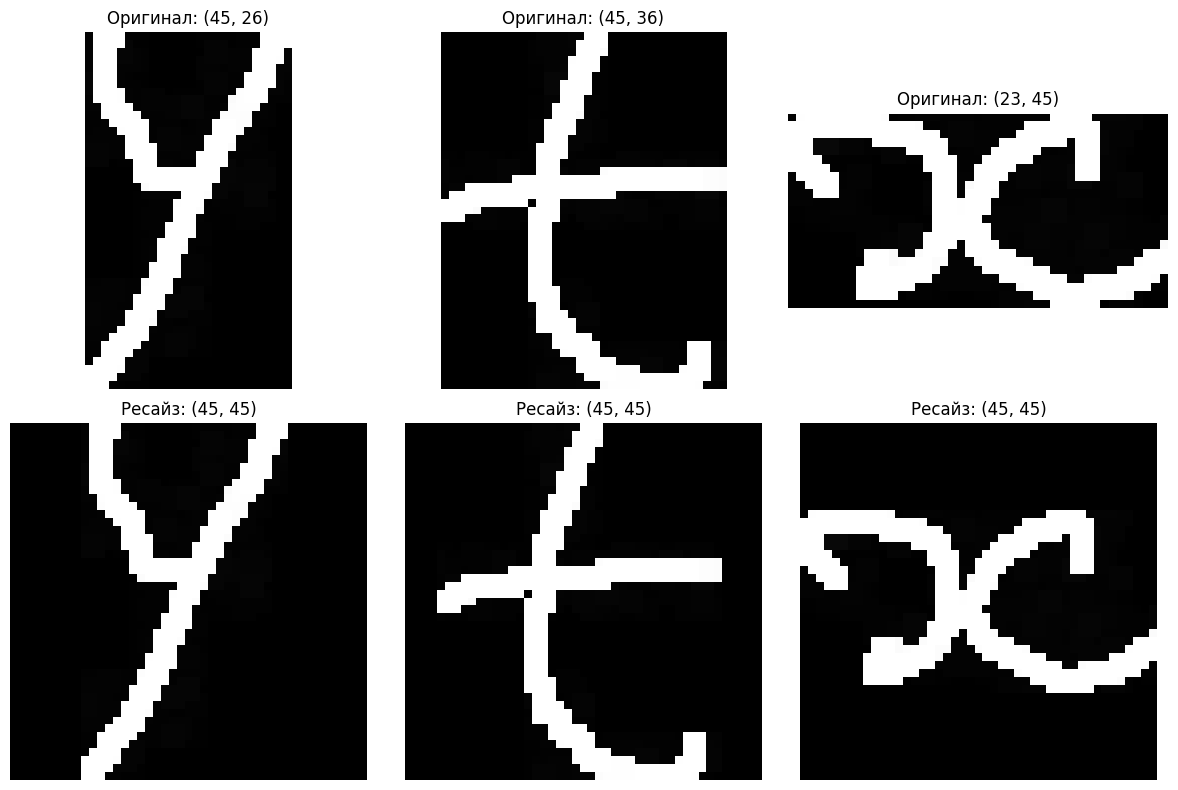

In [ ]:
def center_in_45(image, target_size=45):
    h, w = image.shape
    
    squared = np.zeros((target_size, target_size), dtype=np.uint8)
    
    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2
    
    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

all_data_img_45 = []

seq_data = all_data_img[0]  
sequence_text = seq_data['sequence_text']
symbols_data = seq_data['symbols']

symbols_sorted = sorted(symbols_data, key=lambda item: item[0])

resized_symbols = []
for x, symbol_img in symbols_sorted: 
    original_size = symbol_img.shape
    resized_img = center_in_45(symbol_img)
    resized_symbols.append((x, resized_img))

all_data_img_45.append({
    'sequence_text': sequence_text,
    'symbols': resized_symbols 
})

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(min(3, len(all_data_img_45[0]['symbols']))):
    orig_img = all_data_img[0]['symbols'][i][1]
    resized_img = all_data_img_45[0]['symbols'][i][1]
    
    axes[0, i].imshow(orig_img, cmap='gray')
    axes[0, i].set_title(f'Оригинал: {orig_img.shape}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(resized_img, cmap='gray')
    axes[1, i].set_title(f'Ресайз: {resized_img.shape}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Пункт 3: тренировка модели k-nn

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
def load_training_data(data_path, symbols, train_size=0.7):
    X_train, y_train = [], []
    
    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)
        images = [f for f in os.listdir(symbol_path) if os.path.isfile(os.path.join(symbol_path, f))]
        images.sort()
        
        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        
        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                X_train.append(img.flatten())
                if (symbol == 'X'):
                    symbol = 'x'
                if (symbol == 'times'):
                    symbol = '*'
                y_train.append(symbol)
    
    return np.array(X_train), np.array(y_train)

In [9]:
symbols = ['0','1','2','3','4','5','6','7','8','9','+','-','times','t','X','y','w','h','(',')',',']
X_train, y_train = load_training_data('C:\\improc\\hw9\\', symbols, 0.8)
print(f"Обучающая выборка: {len(X_train)} изображений")

Обучающая выборка: 180225 изображений


In [10]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn7 = KNeighborsClassifier(n_neighbors=7)

In [11]:
knn1.fit(X_train, y_train)
print("Модель k = 1 успешно обучена!")

Модель k = 1 успешно обучена!


In [12]:
knn3.fit(X_train, y_train)
print("Модель k = 3 успешно обучена!")

Модель k = 3 успешно обучена!


In [13]:
knn5.fit(X_train, y_train)
print("Модель k = 5 успешно обучена!")

Модель k = 5 успешно обучена!


In [14]:
knn7.fit(X_train, y_train)
print("Модель k = 7 успешно обучена!")

Модель k = 7 успешно обучена!


Пункт 4: применение k-nn для решения задачи классификации, вывод результата

In [15]:
def predict_symbol(model, image):
    image = cv2.bitwise_not(image)
    img_flat = image.flatten()
    prediction = model.predict([img_flat])
    return prediction[0]


 Последовательность:
Оригинал: 'ytx4463+2)'

МОДЕЛЬ: knn1


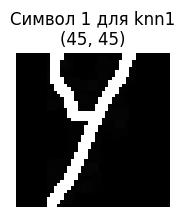

    Предсказан как: 'y'


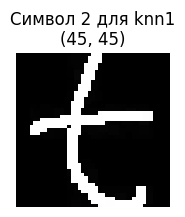

    Предсказан как: 't'


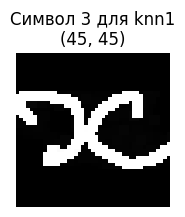

    Предсказан как: 'x'


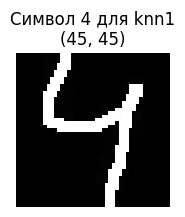

    Предсказан как: '4'


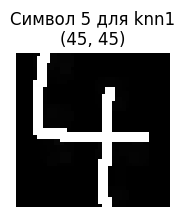

    Предсказан как: '4'


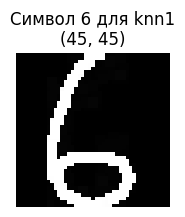

    Предсказан как: '6'


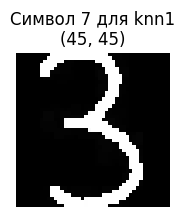

    Предсказан как: '3'


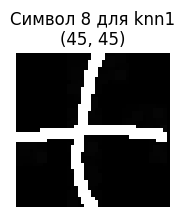

    Предсказан как: '+'


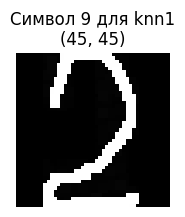

    Предсказан как: '2'


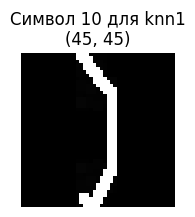

    Предсказан как: ')'
Предсказано: 'ytx4463+2)'
Accuracy для knn1: 1.00 (10/10 символов)

МОДЕЛЬ: knn3


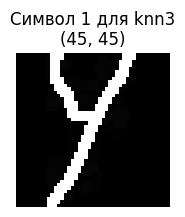

    Предсказан как: 'y'


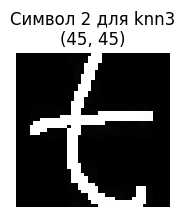

    Предсказан как: 't'


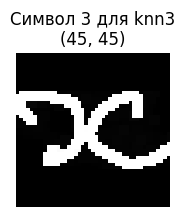

    Предсказан как: 'x'


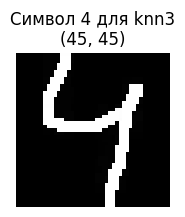

    Предсказан как: '4'


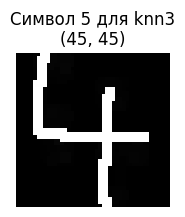

    Предсказан как: '4'


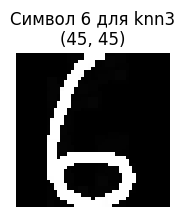

    Предсказан как: '6'


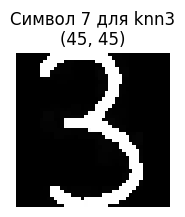

    Предсказан как: '3'


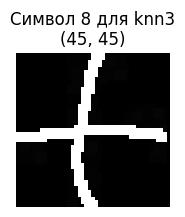

    Предсказан как: '+'


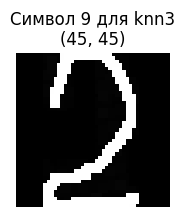

    Предсказан как: '2'


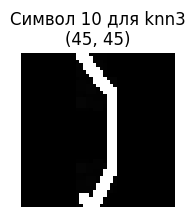

    Предсказан как: ')'
Предсказано: 'ytx4463+2)'
Accuracy для knn3: 1.00 (10/10 символов)

МОДЕЛЬ: knn5


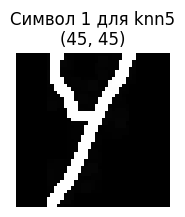

    Предсказан как: 'y'


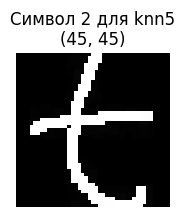

    Предсказан как: 't'


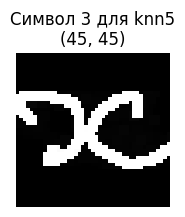

    Предсказан как: 'x'


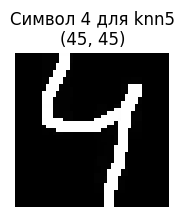

    Предсказан как: '4'


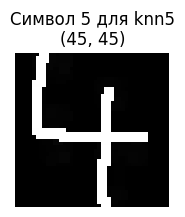

    Предсказан как: '4'


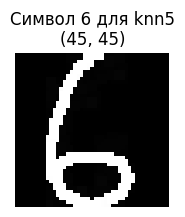

    Предсказан как: '6'


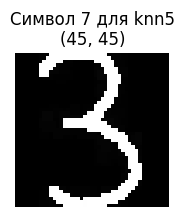

    Предсказан как: '3'


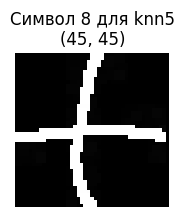

    Предсказан как: '+'


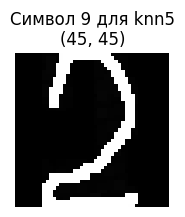

    Предсказан как: '2'


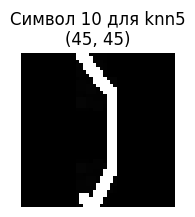

    Предсказан как: ')'
Предсказано: 'ytx4463+2)'
Accuracy для knn5: 1.00 (10/10 символов)

МОДЕЛЬ: knn7


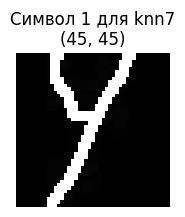

    Предсказан как: 'y'


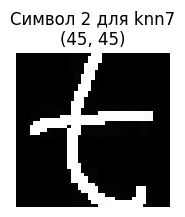

    Предсказан как: 't'


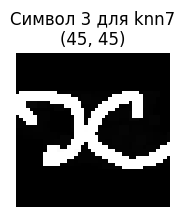

    Предсказан как: 'x'


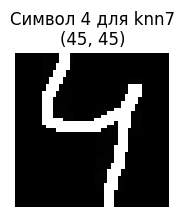

    Предсказан как: '4'


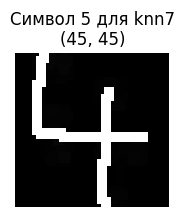

    Предсказан как: '-'


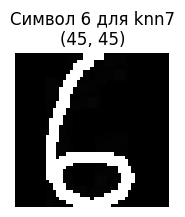

    Предсказан как: '6'


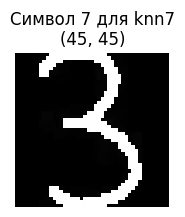

    Предсказан как: '3'


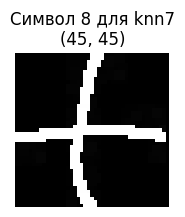

    Предсказан как: '+'


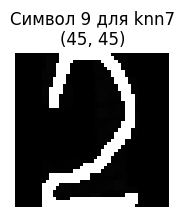

    Предсказан как: '2'


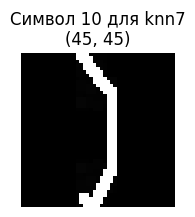

    Предсказан как: ')'
Предсказано: 'ytx4-63+2)'
   Ошибка в позиции 5: ожидалось '4', получено '-'
Accuracy для knn7: 0.90 (9/10 символов)

ПО ВСЕМ МОДЕЛЯМ:
knn1  | Accuracy: 100.00% | 10/10 | Предсказание: 'ytx4463+2)'
knn3  | Accuracy: 100.00% | 10/10 | Предсказание: 'ytx4463+2)'
knn5  | Accuracy: 100.00% | 10/10 | Предсказание: 'ytx4463+2)'
knn7  | Accuracy:  90.00% | 9/10 | Предсказание: 'ytx4-63+2)'


In [16]:
seq_data = all_data_img_45[0]
original_text = seq_data['sequence_text']
symbols_data = seq_data['symbols']

print(f"\n Последовательность:")
print(f"Оригинал: '{original_text}'")

models = {
    'knn1': knn1,
    'knn3': knn3, 
    'knn5': knn5,
    'knn7': knn7
}

results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"{'='*50}")
    
    predicted_symbols = []
    
    for j, (x, symbol_img) in enumerate(symbols_data):
        plt.figure(figsize=(3, 2))
        plt.imshow(symbol_img, cmap='gray')
        plt.title(f'Символ {j+1} для {model_name}\n{symbol_img.shape}')
        plt.axis('off')
        plt.show()
        
        predicted_char = predict_symbol(model, symbol_img)
        predicted_symbols.append(predicted_char)
        print(f"    Предсказан как: '{predicted_char}'")
    
    predicted_text = ''.join(predicted_symbols)
    print(f"Предсказано: '{predicted_text}'")
    
    correct_chars = sum(1 for orig, pred in zip(original_text, predicted_text) if orig == pred)
    total_chars = len(original_text)
    accuracy = correct_chars / total_chars
    
    if original_text != predicted_text:
        for idx, (orig_char, pred_char) in enumerate(zip(original_text, predicted_text)):
            if orig_char != pred_char:
                print(f"   Ошибка в позиции {idx+1}: ожидалось '{orig_char}', получено '{pred_char}'")
    
    print(f"Accuracy для {model_name}: {accuracy:.2f} ({correct_chars}/{total_chars} символов)")
    
    results[model_name] = {
        'predicted_text': predicted_text,
        'accuracy': accuracy,
        'correct_chars': correct_chars,
        'total_chars': total_chars
    }

print(f"\n{'='*60}")
print("ПО ВСЕМ МОДЕЛЯМ:")
print(f"{'='*60}")

sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for model_name, result in sorted_results:
    accuracy_percent = result['accuracy'] * 100
    print(f"{model_name:5} | Accuracy: {accuracy_percent:6.2f}% | {result['correct_chars']}/{result['total_chars']} | Предсказание: '{result['predicted_text']}'")